In [11]:
# rerun if needed
# %pip install pandas matplotlib seaborn scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

data = pd.read_csv('teams.csv')
# all numeric columns
numeric_data = data.select_dtypes(include='number')
print(data.columns.tolist())

['team_id', 'team_name', 'season', 'league_id', 'team_form', 'games_played_home', 'games_played_away', 'wins_home', 'losses_home', 'draws_home', 'wins_away', 'losses_away', 'draws_away', 'stadium_capacity', 'team_country', 'goals_scored_0_15', 'goals_scored_16_30', 'goals_scored_31_45', 'goals_scored_46_60', 'goals_scored_61_75', 'goals_scored_76_90', 'goals_scored_91_105', 'goals_scored_106_120', 'goals_conceded_0_15', 'goals_conceded_16_30', 'goals_conceded_31_45', 'goals_conceded_46_60', 'goals_conceded_61_75', 'goals_conceded_76_90', 'goals_conceded_91_105', 'goals_conceded_106_120', 'clean_sheets', 'failed_to_score', 'penalty_success_rate', 'over_0_5', 'under_0_5', 'over_1_5', 'under_1_5', 'over_2_5', 'under_2_5', 'over_3_5', 'under_3_5', 'over_4_5', 'under_4_5', 'yellow_cards_0_15', 'yellow_cards_16_30', 'yellow_cards_31_45', 'yellow_cards_46_60', 'yellow_cards_61_75', 'yellow_cards_76_90', 'yellow_cards_91_105', 'yellow_cards_106_120', 'red_cards_0_15', 'red_cards_16_30', 'red_c

In [12]:
# Count the number of missing values in each column
missing_values = data.isnull().sum()
# Filter and print only the columns with missing values greater than zero
non_zero_missing = missing_values[missing_values > 0]
print(non_zero_missing)

team_form            430
team_country        1497
lineups_per_game    1497
dtype: int64


In [13]:
# after finding 206 null team_forms - we'll delte those rows - this teams weren't in the league at this season

updated_data = data.loc[~((data['games_played_home'] == 0) & 
                       (data['games_played_away'] == 0) & 
                       (data['wins_home'] == 0) & 
                       (data['losses_home'] == 0) & 
                       (data['draws_home'] == 0) & 
                       (data['wins_away'] == 0) & 
                       (data['losses_away'] == 0) & 
                       (data['draws_away'] == 0) & 
                       data['team_form'].isnull())]

# remove the column lineups_per_game - it includes at each fixture
updated_data = updated_data.drop(columns=['lineups_per_game'])

#checking
# Count the number of missing values in each column
missing_values = updated_data.isnull().sum()
# Filter and print only the columns with missing values greater than zero
non_zero_missing = missing_values[missing_values > 0]
print(non_zero_missing)

team_country    1067
dtype: int64


In [14]:
# create dict for each league and it's country to fill team_country

team_country_dict = {39: 'England', 140:'Spain'}
updated_data['team_country'] = updated_data['league_id'].map(team_country_dict)

#checking
# Count the number of missing values in each column
missing_values = updated_data.isnull().sum()
# Filter and print only the columns with missing values greater than zero
non_zero_missing = missing_values[missing_values > 0]
print(non_zero_missing)


team_country    567
dtype: int64


In [15]:
# check how many teams in each season
# Group by 'season' and count unique 'team_id'
team_count_per_season = updated_data.groupby('season')['team_id'].nunique()

# Print the result
print(team_count_per_season)

season
2010     20
2011     20
2012     20
2013     20
2014     20
2015     98
2016     98
2017     98
2018     99
2019     99
2020    100
2021    100
2022     99
2023     98
2024     78
Name: team_id, dtype: int64


Encode all the non numeric columns

In [16]:
# print all the non numeric columns
# Select columns that are non-numeric
non_numeric_data = updated_data.select_dtypes(exclude='number')

# Print the non-numeric data
print(non_numeric_data.columns.tolist())

# drop the column of team_name - we have team_id it's enough
# updated_data = updated_data.drop(columns=['team_name'])

# drop games_played_home  games_played_away - not relevant - all teams play the same amount of games + it will have good indicator on the fixtures table
# updated_data = updated_data.drop(columns=['games_played_home','games_played_away'])


['team_name', 'team_form', 'team_country']


In [17]:
# encode the team_country by get_dummies
dummies = pd.get_dummies(updated_data['team_country'], prefix='team_country')
#  include these dummy variables back into original DataFrame and drop the original column
updated_data = pd.concat([updated_data, dummies], axis=1)
updated_data.drop('team_country', axis=1, inplace=True)
# convert in into int and not true/false
dummy_cols = [col for col in updated_data.columns if any(prefix in col for prefix in ['team_country_'])]
updated_data[dummy_cols] = updated_data[dummy_cols].astype(int)

# To see the encoded DataFrame
print(updated_data.columns.tolist())


['team_id', 'team_name', 'season', 'league_id', 'team_form', 'games_played_home', 'games_played_away', 'wins_home', 'losses_home', 'draws_home', 'wins_away', 'losses_away', 'draws_away', 'stadium_capacity', 'goals_scored_0_15', 'goals_scored_16_30', 'goals_scored_31_45', 'goals_scored_46_60', 'goals_scored_61_75', 'goals_scored_76_90', 'goals_scored_91_105', 'goals_scored_106_120', 'goals_conceded_0_15', 'goals_conceded_16_30', 'goals_conceded_31_45', 'goals_conceded_46_60', 'goals_conceded_61_75', 'goals_conceded_76_90', 'goals_conceded_91_105', 'goals_conceded_106_120', 'clean_sheets', 'failed_to_score', 'penalty_success_rate', 'over_0_5', 'under_0_5', 'over_1_5', 'under_1_5', 'over_2_5', 'under_2_5', 'over_3_5', 'under_3_5', 'over_4_5', 'under_4_5', 'yellow_cards_0_15', 'yellow_cards_16_30', 'yellow_cards_31_45', 'yellow_cards_46_60', 'yellow_cards_61_75', 'yellow_cards_76_90', 'yellow_cards_91_105', 'yellow_cards_106_120', 'red_cards_0_15', 'red_cards_16_30', 'red_cards_31_45', 're

to deal with team form - we will convert each form to ternary num and then to decimal - L=0,D=1,W=2

In [18]:
# dict of LDW values
form_dict = {'L':0, 'D':1, 'W':3}

def process_team_form(row):
    # Replace each character in the string according to the dictionary
    form_numeric_string = ''.join(str(form_dict[char]) for char in row['team_form'])
    return int(form_numeric_string)  

updated_data_copy = updated_data.copy()

# Apply the function to the DataFrame
updated_data_copy['team_form_numeric'] = updated_data_copy.apply(process_team_form, axis=1)

# update it on the origin df
# Apply the function to the team_form column and create a new team_form_decimal column
updated_data['team_form_numeric'] = updated_data_copy[['team_form_numeric']]

# Drop the original team_form column
updated_data.drop('team_form', axis=1, inplace=True)

print(updated_data['team_form_numeric'])





0       10133133000100333013003331103103013330
2       30101313000330003300003313311033131130
3          10013013130300330013110113000303000
4         331103330310113333031330301330030133
5        3031033331331333130131131133333130013
                         ...                  
1490    10110011001000011001113103001030003030
1491    33331333133133310011111303133101330303
1492    33333333133133013333333333013131330133
1493    30333303333313130101103330333101333313
1496      131031303333333333333331333333333303
Name: team_form_numeric, Length: 1067, dtype: object


normalize the integer values

In [19]:
print(updated_data.head())

# normalize stadium capacity with min-max - between 0-1 - not standartization cause I can't assume it normally distribute
# Install scikit-learn if not already installed
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
min_max_scaler = MinMaxScaler()

# Fit and transform 'stadium_capacity'
updated_data['stadium_capacity_normalized'] = min_max_scaler.fit_transform(updated_data[['stadium_capacity']])

print(updated_data['stadium_capacity_normalized'])


   team_id          team_name  season  league_id  games_played_home  \
0       39             Wolves    2018         39                 19   
2       44            Burnley    2019         39                 19   
3       44            Burnley    2020         39                 19   
4       48           West Ham    2020         39                 19   
5       33  Manchester United    2020         39                 19   

   games_played_away  wins_home  losses_home  draws_home  wins_away  ...  \
0                 19         10            5           4          6  ...   
2                 19          8            7           4          7  ...   
3                 19          4            9           6          6  ...   
4                 19         10            5           4          9  ...   
5                 19          9            6           4         12  ...   

   red_cards_16_30  red_cards_31_45  red_cards_46_60  red_cards_61_75  \
0                1                0        

In [20]:
# add points for every 5 fixtures
def calculate_points(data):
    max_fixtures = 40
    for i in range(5, max_fixtures+1, 5):
        data[f'fixture_{i}_points'] = data['team_form_numeric'].apply(
            lambda x: sum(int(y) for y in str(x)[:i])
        )

    # Calculate the end season points, consider the length of the string for leagues with fewer than 40 fixtures
    data['end_season_points'] = data['team_form_numeric'].apply(
        lambda x: sum(int(y) for y in str(x))
    )

    # For leagues with fewer than 40 fixtures, copy the end_season_points to fixture_40_points
    data['fixture_40_points'] = data.apply(
        lambda row: row['end_season_points'] if 'fixture_40_points' not in row else row['fixture_40_points'],
        axis=1
    )

    return data

# Assuming updated_data is your DataFrame
updated_data = calculate_points(updated_data)
print(updated_data[['fixture_5_points', 'fixture_10_points', 'fixture_15_points', 'fixture_20_points', 'fixture_25_points', 'fixture_30_points', 'fixture_35_points', 'fixture_40_points', 'end_season_points']])


      fixture_5_points  fixture_10_points  fixture_15_points  \
0                    8                 15                 19   
2                    5                 12                 18   
3                    5                 13                 19   
4                    8                 20                 26   
5                    7                 20                 33   
...                ...                ...                ...   
1490                 3                  5                  6   
1491                13                 26                 39   
1492                15                 28                 38   
1493                12                 24                 35   
1496                 8                 18                 33   

      fixture_20_points  fixture_25_points  fixture_30_points  \
0                    29                 38                 44   
2                    24                 31                 39   
3                    26             

In [21]:
# add "grades" columns for each 5 fixtures - the success rate
def add_success_rate(data):
    max_fixtures = 40
    # Add grades for each 5 fixtures
    for i in range(5, max_fixtures+1, 5):
        max_points = 3 * i
        column_name = f'fixture_{i}_points'
        grade_column = f'fixture_{i}_grade'
        if column_name in data.columns:
            data[grade_column] = data[column_name] / max_points

    # Calculate end of season grade
    data['end_season_grade'] = data['end_season_points'] / (3*(data['games_played_home'] + data['games_played_away']))

    return data

# Assuming updated_data is your DataFrame
updated_data = add_success_rate(updated_data)
print(updated_data[['fixture_5_grade', 'fixture_10_grade', 'fixture_15_grade', 'fixture_20_grade', 'fixture_25_grade', 'fixture_30_grade', 'fixture_35_grade', 'fixture_40_grade', 'end_season_grade']])


      fixture_5_grade  fixture_10_grade  fixture_15_grade  fixture_20_grade  \
0            0.533333          0.500000          0.422222          0.483333   
2            0.333333          0.400000          0.400000          0.400000   
3            0.333333          0.433333          0.422222          0.433333   
4            0.533333          0.666667          0.577778          0.633333   
5            0.466667          0.666667          0.733333          0.683333   
...               ...               ...               ...               ...   
1490         0.200000          0.166667          0.133333          0.150000   
1491         0.866667          0.866667          0.866667          0.700000   
1492         1.000000          0.933333          0.844444          0.850000   
1493         0.800000          0.800000          0.777778          0.666667   
1496         0.533333          0.600000          0.733333          0.800000   

      fixture_25_grade  fixture_30_grade  fixture_3

In [22]:
print(updated_data.head())

   team_id          team_name  season  league_id  games_played_home  \
0       39             Wolves    2018         39                 19   
2       44            Burnley    2019         39                 19   
3       44            Burnley    2020         39                 19   
4       48           West Ham    2020         39                 19   
5       33  Manchester United    2020         39                 19   

   games_played_away  wins_home  losses_home  draws_home  wins_away  ...  \
0                 19         10            5           4          6  ...   
2                 19          8            7           4          7  ...   
3                 19          4            9           6          6  ...   
4                 19         10            5           4          9  ...   
5                 19          9            6           4         12  ...   

   end_season_points  fixture_5_grade  fixture_10_grade  fixture_15_grade  \
0                 57         0.533333  

In [23]:
# Calculate the correlation matrix
# this makes a problem when we leave the team_name - it's not numeric
# correlation_matrix = updated_data.corr()
updated_data = updated_data.drop(columns=['team_name'])
correlation_matrix = updated_data.corr()

# Find pairs with a correlation greater than 0.7
high_corr_pairs = {}
for row in correlation_matrix.columns:
    for col in correlation_matrix.index:
        if row != col and abs(correlation_matrix.loc[row, col]) > 0.7:
            # Sort the row and column names to avoid duplicates like (A, B) and (B, A)
            sorted_pair = tuple(sorted((row, col)))
            high_corr_pairs[sorted_pair] = correlation_matrix.loc[row, col]

# Display high correlation pairs
for pair, corr_value in high_corr_pairs.items():
    print(f"{pair}: {corr_value:.2f}")

('league_id', 'team_id'): 0.81
('league_id', 'team_country_England'): -0.71
('games_played_away', 'games_played_home'): 1.00
('games_played_home', 'over_0_5'): 0.80
('games_played_home', 'under_2_5'): 0.83
('games_played_home', 'under_3_5'): 0.94
('games_played_home', 'under_4_5'): 0.98
('games_played_away', 'over_0_5'): 0.80
('games_played_away', 'under_2_5'): 0.83
('games_played_away', 'under_3_5'): 0.94
('games_played_away', 'under_4_5'): 0.98
('clean_sheets', 'wins_home'): 0.73
('over_0_5', 'wins_home'): 0.73
('over_1_5', 'wins_home'): 0.82
('over_2_5', 'wins_home'): 0.77
('fixture_15_points', 'wins_home'): 0.79
('fixture_20_points', 'wins_home'): 0.85
('fixture_25_points', 'wins_home'): 0.88
('fixture_30_points', 'wins_home'): 0.90
('fixture_35_points', 'wins_home'): 0.91
('fixture_40_points', 'wins_home'): 0.92
('end_season_points', 'wins_home'): 0.92
('fixture_15_grade', 'wins_home'): 0.79
('fixture_20_grade', 'wins_home'): 0.85
('fixture_25_grade', 'wins_home'): 0.88
('fixture_

In [24]:
print(updated_data.columns.tolist())

['team_id', 'season', 'league_id', 'games_played_home', 'games_played_away', 'wins_home', 'losses_home', 'draws_home', 'wins_away', 'losses_away', 'draws_away', 'stadium_capacity', 'goals_scored_0_15', 'goals_scored_16_30', 'goals_scored_31_45', 'goals_scored_46_60', 'goals_scored_61_75', 'goals_scored_76_90', 'goals_scored_91_105', 'goals_scored_106_120', 'goals_conceded_0_15', 'goals_conceded_16_30', 'goals_conceded_31_45', 'goals_conceded_46_60', 'goals_conceded_61_75', 'goals_conceded_76_90', 'goals_conceded_91_105', 'goals_conceded_106_120', 'clean_sheets', 'failed_to_score', 'penalty_success_rate', 'over_0_5', 'under_0_5', 'over_1_5', 'under_1_5', 'over_2_5', 'under_2_5', 'over_3_5', 'under_3_5', 'over_4_5', 'under_4_5', 'yellow_cards_0_15', 'yellow_cards_16_30', 'yellow_cards_31_45', 'yellow_cards_46_60', 'yellow_cards_61_75', 'yellow_cards_76_90', 'yellow_cards_91_105', 'yellow_cards_106_120', 'red_cards_0_15', 'red_cards_16_30', 'red_cards_31_45', 'red_cards_46_60', 'red_cards

## lets try to encode teams

### scale

In [25]:
# Drop unwanted columns from updated_data
updated_data = updated_data.drop(columns=['team_id','season', 'league_id','games_played_home','games_played_away','stadium_capacity'])

# Check if there are any missing values before scaling
print(f"Do we still have any nulls before scaling? {updated_data.isnull().any().any()}")

# Scale all the remaining data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Apply scaling to all the data
team_data_scaled = scaler.fit_transform(updated_data)

# Convert the scaled data back into a DataFrame with correct column names
team_data_scaled_df = pd.DataFrame(team_data_scaled, columns=updated_data.columns)

# Check if there are any missing values after scaling
print(f"Do we still have any nulls after scaling? {team_data_scaled_df.isnull().any().any()}")

# Save the scaled data
save_update_scaled_data = team_data_scaled_df



Do we still have any nulls before scaling? False
Do we still have any nulls after scaling? False


## model tests?!?!??

### pca
bina said on pca: 
PCA is typically used when you want to reduce the dimensionality of the data while retaining as much of the variance (information) as possible. It’s a linear method, so it works best if the data has linear relationships between features.
the mean should be close to 0 and the standard deviation should be 1.

In [26]:
pca_data=save_update_scaled_data
# Check the mean and standard deviation of the scaled data 
print("Mean of scaled data:")
print(pca_data.mean())

print("Standard deviation of scaled data:")
print(pca_data.std())

print (pca_data.head())


Mean of scaled data:
wins_home          -4.661480e-17
losses_home        -3.995554e-17
draws_home          1.165370e-16
wins_away           1.198666e-16
losses_away         6.659257e-18
                        ...     
fixture_25_grade    3.462814e-16
fixture_30_grade    1.731407e-16
fixture_35_grade    3.729184e-16
fixture_40_grade   -6.659257e-17
end_season_grade   -5.993331e-17
Length: 73, dtype: float64
Standard deviation of scaled data:
wins_home           1.000469
losses_home         1.000469
draws_home          1.000469
wins_away           1.000469
losses_away         1.000469
                      ...   
fixture_25_grade    1.000469
fixture_30_grade    1.000469
fixture_35_grade    1.000469
fixture_40_grade    1.000469
end_season_grade    1.000469
Length: 73, dtype: float64
   wins_home  losses_home  draws_home  wins_away  losses_away  draws_away  \
0   0.605057    -0.103386   -0.182753   0.209719     0.070322    0.297098   
1   0.067061     0.557171   -0.182753   0.515415    -0

#### pre thinking for pca

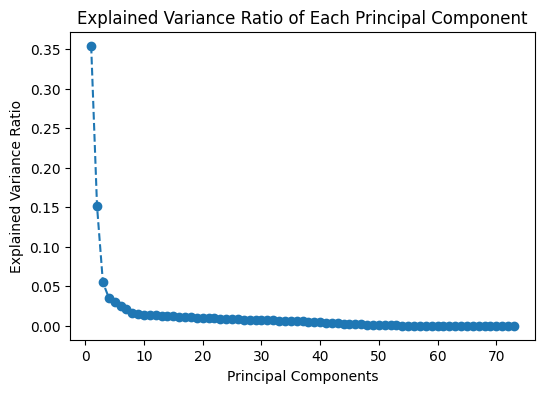

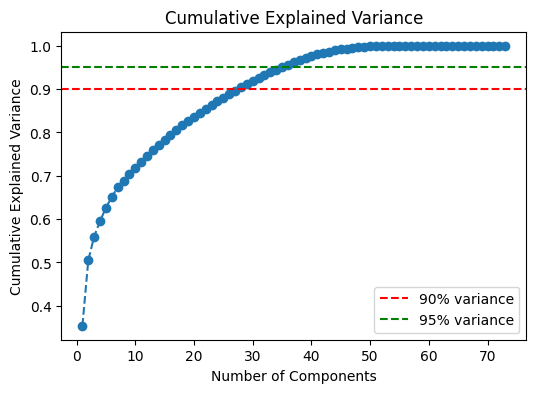

Cumulative explained variance:
[0.35410768 0.50512511 0.55990398 0.59541156 0.62598764 0.65138782
 0.67303636 0.68906004 0.70375767 0.7179256  0.7318196  0.74559396
 0.7583609  0.77063818 0.78277333 0.79429894 0.80542899 0.8162644
 0.82626464 0.83618488 0.84568278 0.85489201 0.86377659 0.87226134
 0.8803593  0.88832158 0.89606116 0.90370492 0.91119011 0.91844129
 0.9254583  0.93223906 0.93873936 0.94511293 0.95098341 0.95659877
 0.96199565 0.96717202 0.97171174 0.97588433 0.97982762 0.9835015
 0.98651026 0.989068   0.99140072 0.99324298 0.99504783 0.99646361
 0.99767917 0.99833582 0.99890346 0.99926628 0.99961295 0.99981013
 0.99996867 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
Number of components that explain 95.0% variance: 35


In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to the entire dataset (pca_data), which contains all the features
pca = PCA()  # Apply PCA to all the features in pca_data
pca.fit(pca_data)  # Fit PCA on the entire dataset

# Plot the explained variance ratio for each component
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Cumulative explained variance plot
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(0.90, color='r', linestyle='--', label='90% variance')
plt.axhline(0.95, color='g', linestyle='--', label='95% variance')
plt.legend()
plt.show()


# Print the cumulative variance to check which component number to choose
print("Cumulative explained variance:")
print(cumulative_variance)

threshold = 0.95  # You can adjust this based on your needs
n_components = (cumulative_variance >= threshold).argmax() + 1
print(f"Number of components that explain {threshold * 100}% variance: {n_components}")




#### pca and check if good

In [28]:
# ill choose 4 components i think it's enough
pca = PCA(n_components=4)
pca_data = pca.fit_transform(team_data_scaled_df)

# Check the shape of pca_data
print(f"Shape of pca_data: {pca_data.shape}")

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio of each component: {explained_variance_ratio}")

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print(f"Cumulative explained variance: {cumulative_explained_variance}")

# i get that 4 components explains 64% of the variance - i dont know if enough.. maybe a different type of 
# scaling will help 
# or just take more components but each not really helping a lot so idk

Shape of pca_data: (1067, 4)
Explained variance ratio of each component: [0.35410768 0.15101743 0.05477886 0.03550758]
Cumulative explained variance: [0.35410768 0.50512511 0.55990398 0.59541156]


### t nse

#### pre thinking of tnse

Shape of 2D t-SNE results: (1067, 2)


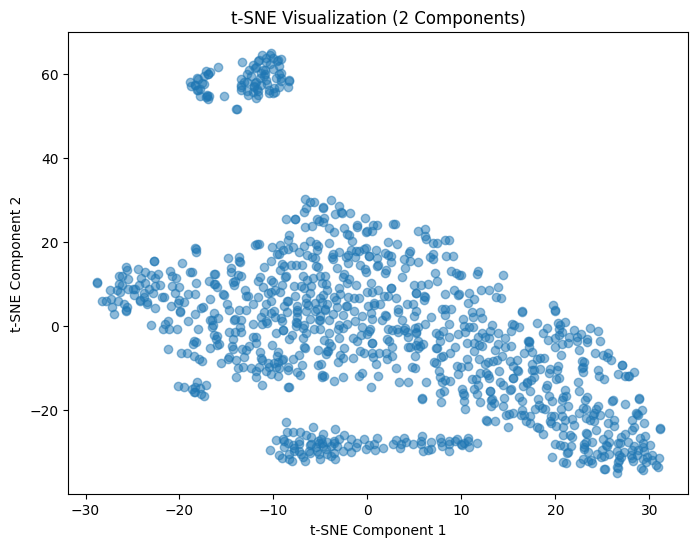

Shape of 3D t-SNE results: (1067, 3)


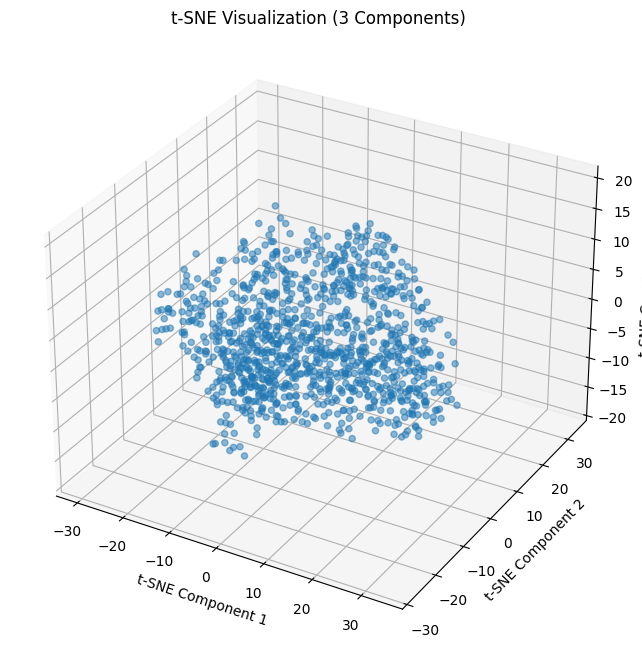

In [29]:
from sklearn.manifold import TSNE

tnse_data=save_update_scaled_data

# Apply t-SNE: Reduce to 2 or 3 components
tsne = TSNE(n_components=2, random_state=42)  # You can also set n_components=3 for 3D visualization
tsne_results = tsne.fit_transform(tnse_data)

# Apply t-SNE: Reduce to 2 components
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_results_2d = tsne_2d.fit_transform(tnse_data)

# Check the shape of the transformed data (2 components)
print(f"Shape of 2D t-SNE results: {tsne_results_2d.shape}")

# Visualize the 2D t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1], alpha=0.5)
plt.title("t-SNE Visualization (2 Components)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Apply t-SNE: Reduce to 3 components
tsne_3d = TSNE(n_components=3, random_state=42)
tsne_results_3d = tsne_3d.fit_transform(tnse_data)

# Check the shape of the transformed data (3 components)
print(f"Shape of 3D t-SNE results: {tsne_results_3d.shape}")

# Visualize the 3D t-SNE results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results_3d[:, 0], tsne_results_3d[:, 1], tsne_results_3d[:, 2], alpha=0.5)
ax.set_title("t-SNE Visualization (3 Components)")
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.show()

# no need i think

KMeans algo  - i dont think we need this by gilad

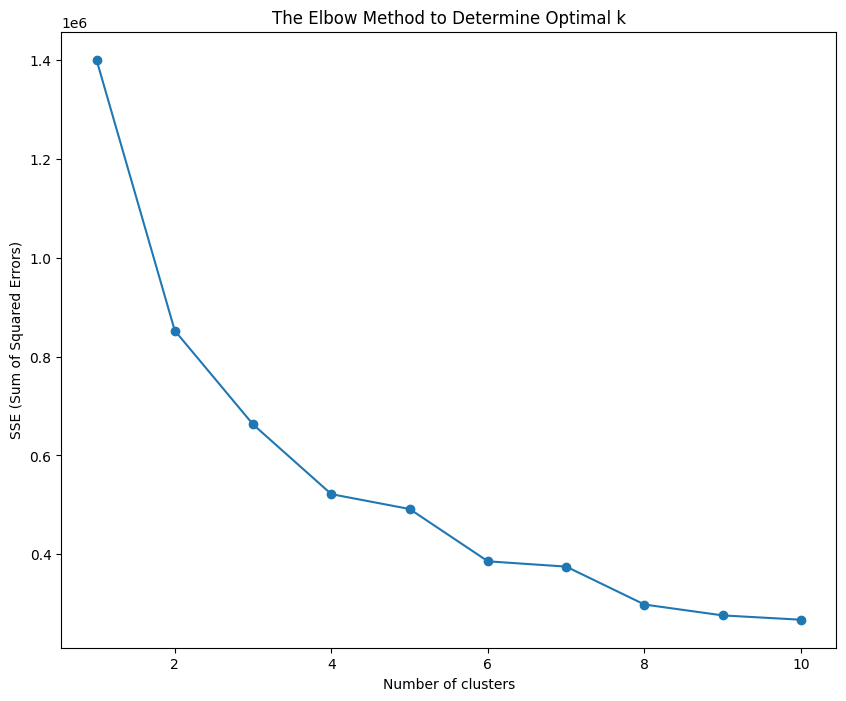

   Cluster  wins_home  losses_home  draws_home  wins_away  losses_away  \
0        0         10            5           4          6            8   
2        0          8            7           4          7            7   
3        0          4            9           6          6           10   
4        3         10            5           4          9            6   
5        3          9            6           4         12            0   

   draws_away  goals_scored_0_15  goals_scored_16_30  goals_scored_31_45  ...  \
0           5                  6                   8                   4  ...   
2           5                  6                   1                   7  ...   
3           3                  9                   5                   6  ...   
4           4                  9                  11                  11  ...   
5           7                  9                  10                   7  ...   

   end_season_points  fixture_5_grade  fixture_10_grade  fixture_15_

KeyError: 'team_name'

In [20]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Prepare the data
# Columns to exclude based on the above criteria
excluded_columns = ['team_id', 'team_name','season', 'league_id', 'stadium_capacity','games_played_home', 'games_played_away']

# Select the columns for clustering, ensuring they are numeric
columns_for_clustering = [col for col in updated_data.select_dtypes(include=['float64', 'int64']).columns if col not in excluded_columns]

# Select data for clustering using the filtered columns
data_for_clustering = updated_data[columns_for_clustering]

# Step 2: Choosing the number of clusters
# Use the Elbow method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_for_clustering)  # Fit the original data directly
    sse.append(kmeans.inertia_)

# Plot SSE for each *k*
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('The Elbow Method to Determine Optimal k')
plt.show()

# Step 3: Apply K-means
# Choose the k after you find the elbow point from the plot, example value k_optimal might be 5 or as determined
k_optimal = 4 
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering)  # Predict using the unnormalized data

# Add cluster labels to your original DataFrame
updated_data['Cluster'] = clusters

# Step 4: Analyze the Results
# Display the DataFrame with clusters
print(updated_data[['Cluster'] + columns_for_clustering].head())

# Optionally, analyze cluster centroids
# Note: Since no scaling was applied in this step, centroids are in the original scale
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=columns_for_clustering)
print(centroids)

print('*'*15)
# Group data by cluster
# Group data by cluster
cluster_groups = updated_data.groupby('Cluster')

# Print the teams and their seasons in each cluster
for cluster, data in cluster_groups:
    print(f"Cluster {cluster}:")
    # Create a list of tuples containing both 'team_name' and 'season'
    team_season_list = list(zip(data['team_name'], data['season']))
    print(team_season_list)
    print("\n")  # Adds a newline for better separation between clusters

    
print('*'*15)


Number of teams in each cluster:
Cluster
0    272
3    121
1     49
2     18
Name: count, dtype: int64


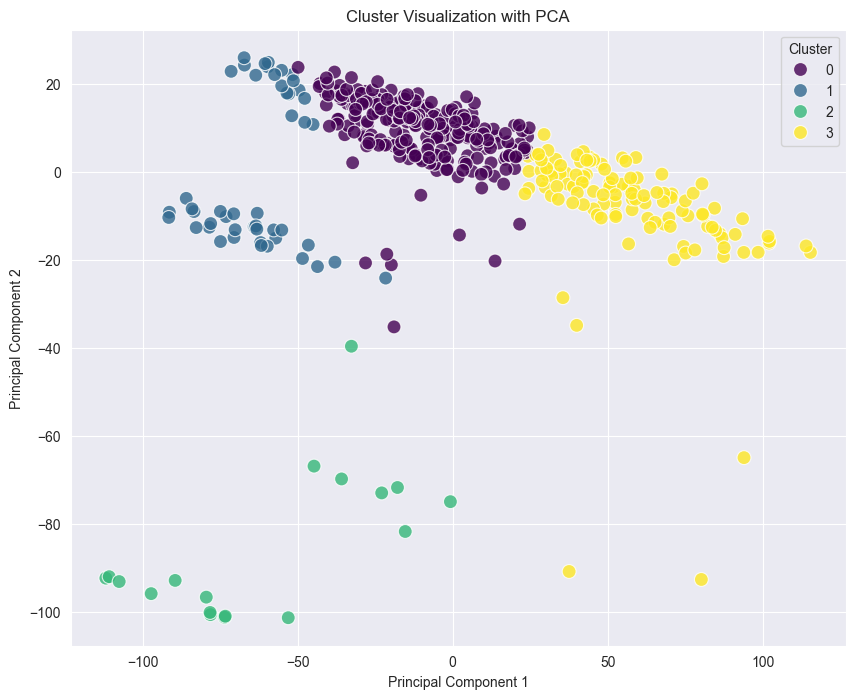

In [ ]:
# plots to understand it better
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Count teams in each cluster
cluster_counts = updated_data['Cluster'].value_counts()
print("Number of teams in each cluster:")
print(cluster_counts)

# Dimensionality reduction for visualization (using PCA for 2D visualization)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_for_clustering)

# Create a scatter plot of the two PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=updated_data['Cluster'], palette='viridis', s=100, alpha=0.8)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


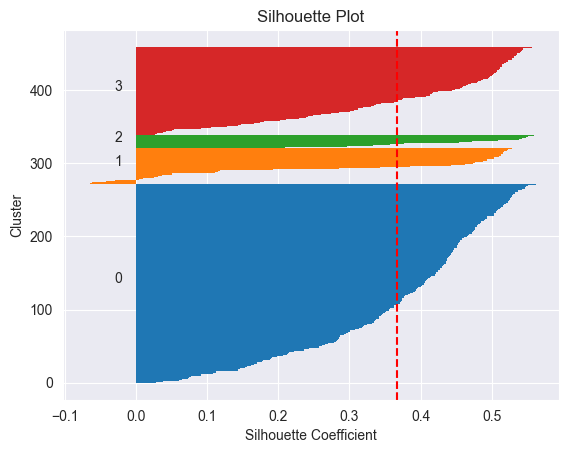

In [ ]:
# Silhouette Plot
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate silhouette scores
silhouette_vals = silhouette_samples(data_for_clustering, clusters)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(range(k_optimal)):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(cluster))
    y_lower += len(cluster_silhouette_vals)

# The silhouette score gives a perspective into the density and separation of the formed clusters
plt.axvline(x=silhouette_score(data_for_clustering, clusters), color="red", linestyle="--")
plt.title('Silhouette Plot')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.show()


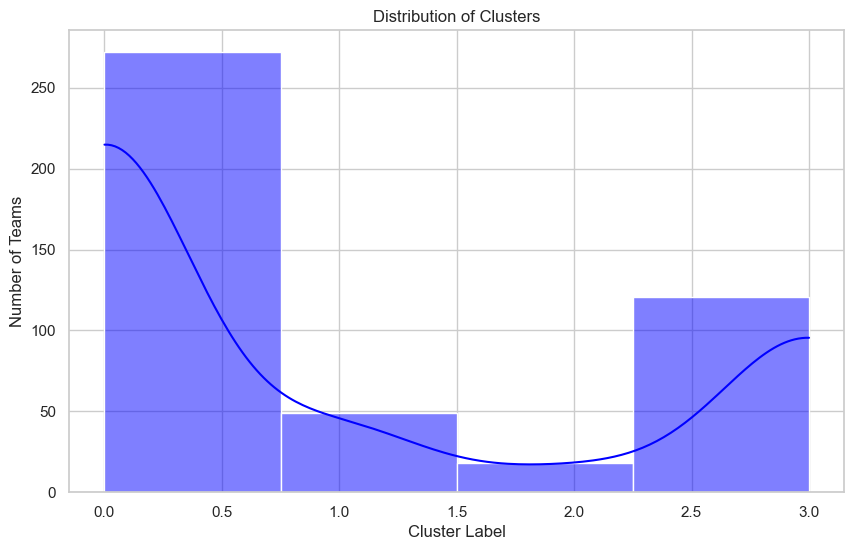

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a distribution plot of cluster labels
plt.figure(figsize=(10, 6))
sns.histplot(updated_data['Cluster'], kde=True, color="blue", bins=len(updated_data['Cluster'].unique()))
plt.title('Distribution of Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Teams')
plt.show()


DBScan algo

Number of teams in each cluster:
-1    460
Name: count, dtype: int64


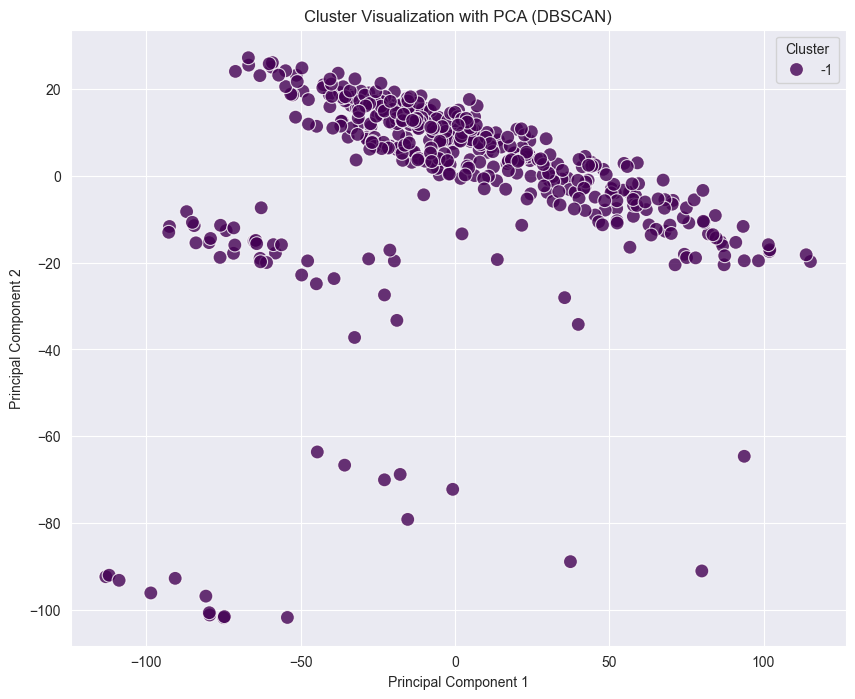

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming updated_data is your DataFrame

# Select only numeric columns for clustering
excluded_columns = ['team_id', 'season', 'league_id', 'stadium_capacity']
columns_for_clustering = [col for col in updated_data.select_dtypes(include=['float64', 'int64']).columns if col not in excluded_columns]
data_for_clustering = updated_data[columns_for_clustering]

# Step 2: Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data_for_clustering)

# Add cluster labels to your original DataFrame
updated_data['Cluster'] = clusters

# Step 3: Analyze the Results
# Count teams in each cluster
cluster_counts = pd.Series(clusters).value_counts()
print("Number of teams in each cluster:")
print(cluster_counts)

# Dimensionality reduction for visualization
pca = PCA(n_components=4)
data_pca = pca.fit_transform(data_for_clustering)

# Create a scatter plot of the two PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=updated_data['Cluster'], palette='viridis', s=100, alpha=0.8)
plt.title('Cluster Visualization with PCA (DBSCAN)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
